## Rice Leaf Disease Detection 






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview
!pip install tf-hub-nightly
!pip install tensorflow==2.0.0-alpha

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.5'


ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview
     |████████████████████████████████| 109 kB 8.3 MB/s 
     |████████████████████████████████| 80.3 MB 52 kB/s 
     |████████████████████████████████| 3.0 MB 59.7 MB/s 
     |████████████████████████████████| 411 kB 47.8 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 2.0.0a0 which is incompatible.
     |████████████████████████████████| 78 kB 4.5 MB/s 
  Attempting uninstall: tensorflow-hub


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-alpha0
Eager mode:  True
Hub version:  0.5.0
GPU is NOT AVAILABLE


### Load the dataset




In [ ]:
zip_file = tf.keras.utils.get_file(origin='/rice-leaf.zip', 
                                   fname='rice-leaf.zip', extract=True)
!unzip /content/drive/MyDrive/Rice_Leaf_Disease_Detection_Classification/updated_model/rice-leaf.zip;


7823360/7816855 [==============================] - 0s 0us/step
Archive:  /content/drive/MyDrive/Rice_Leaf_Disease_Detection_Classification/updated_model/rice-leaf.zip
   creating: rice/
   creating: rice/train/
   creating: rice/train/BlogSpot/
  inflating: rice/train/BlogSpot/IMG_20190419_095712.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_095715.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_095726.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_095736.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_100805.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_103247.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_103508.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_103510.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_103527.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_103531.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_113157.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_113228.jpg  
  inflating: rice/train/BlogSpot/IMG_20190419_1

### Prepare training and validation  dataset


In [ ]:
data_dir = os.path.join(os.path.dirname(zip_file), '/content/rice')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content/rice/train : 155files
total images for validation : /content/rice/validation : 84files


### Label mapping


In [ ]:
!!wget /rice-leaf-diseases-detection/archive/master.zip
!unzip master.zip;

In [ ]:
import json

with open('/content/drive/MyDrive/Rice_Leaf_Disease_Detection_Classification/updated_model/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Hispa', 'LeafBlast', 'BrownSpot']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 3




###Select the Hub/TF2 module to use

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2 with input size (224, 224) and output dimension 1280


### Data Preprocessing




In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 84 images belonging to 3 classes.
Found 155 images belonging to 3 classes.


###Build the model


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [ ]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 2,915,395
Trainable params: 657,411
Non-trainable params: 2,257,984
_________________________________________________________________


### Specify Loss Function and Optimizer

In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model


In [ ]:

EPOCHS=150 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/150
2/2 [==============================] - 24s 12s/step - loss: 2.2576 - accuracy: 0.3846 - val_loss: 2.1254 - val_accuracy: 0.2656
Epoch 2/150
2/2 [==============================] - 18s 9s/step - loss: 1.3236 - accuracy: 0.5055 - val_loss: 0.9372 - val_accuracy: 0.6719
Epoch 3/150
2/2 [==============================] - 21s 11s/step - loss: 1.4387 - accuracy: 0.4688 - val_loss: 0.9192 - val_accuracy: 0.6719
Epoch 4/150
2/2 [==============================] - 17s 9s/step - loss: 0.8298 - accuracy: 0.6094 - val_loss: 1.1160 - val_accuracy: 0.4688
Epoch 5/150
2/2 [==============================] - 22s 11s/step - loss: 0.9287 - accuracy: 0.6264 - val_loss: 1.1645 - val_accuracy: 0.4688
Epoch 6/150
2/2 [==============================] - 17s 9s/step - loss: 0.7198 - accuracy: 0.6923 - val_loss: 0.7911 - val_accuracy: 0.6719
Epoch 7/150
2/2 [==============================] - 15s 8s/step - loss: 0.7738 - accuracy: 0.6813 - val_loss: 0.6954 - val_accuracy: 0.7031
Epoch 8/150
2/2 [=======

###Check Performance


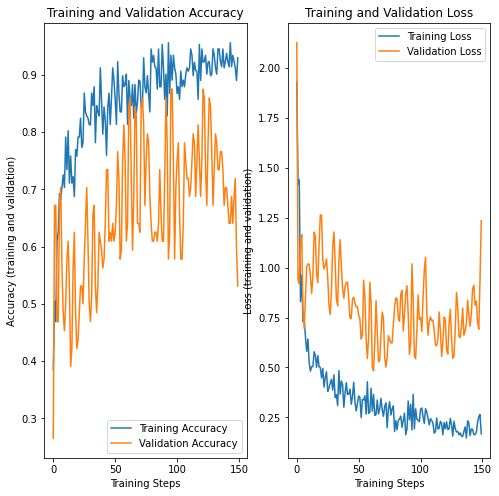

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Random test


In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: LeafBlast, file: LeafBlast/IMG_3106.jpg
PREDICTED: class: Hispa, Accuracy: 0.894776


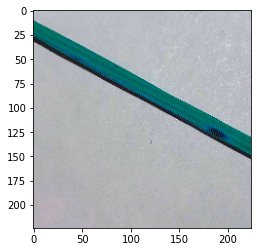

<Figure size 432x288 with 0 Axes>

SOURCE: class: Hispa, file: Hispa/IMG_20190419_131606.jpg
PREDICTED: class: Hispa, Accuracy: 0.956794


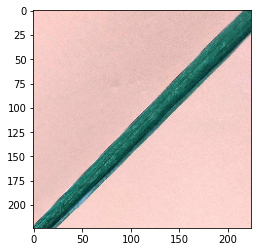

SOURCE: class: LeafBlast, file: LeafBlast/IMG_4868.jpg
PREDICTED: class: Hispa, Accuracy: 0.952164


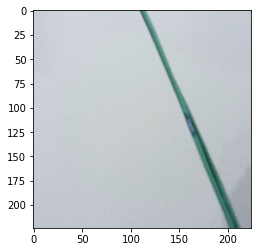

<Figure size 432x288 with 0 Axes>

SOURCE: class: LeafBlast, file: LeafBlast/IMG_3205.jpg
PREDICTED: class: Hispa, Accuracy: 0.978016


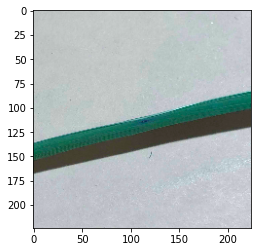

<Figure size 432x288 with 0 Axes>

SOURCE: class: LeafBlast, file: LeafBlast/IMG_5491.jpg
PREDICTED: class: Hispa, Accuracy: 0.895210


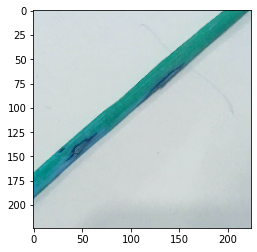

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, Accuracy: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()